# This notebook is all about whether or not I should fill the 0 wind data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)
from sklearn.linear_model import (LinearRegression, 
                                  Ridge,
                                  Lasso,
                                  ElasticNet)
from sklearn.metrics import (mean_squared_error,
                             r2_score, 
                             mean_squared_log_error,
                             mean_absolute_error,
                             make_scorer)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (OneHotEncoder,
                                   PolynomialFeatures, 
                                   KBinsDiscretizer, 
                                   MinMaxScaler)
import xgboost as xgb

In [2]:
df = pd.read_csv('../data/train.csv')

In [3]:
def create_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['week'] = df['datetime'].dt.isocalendar().week
    df['day_of_week'] = df['datetime'].dt.weekday
    df.drop(['datetime'], axis=1, inplace=True)
    
create_datetime(df)

In [4]:
def fill_wind(df):
    # Create two DataFrames 
    # 1 with Wind values = 0
    # 1 without any 0 Wind values
    wind_0 = df[df['windspeed']==0]
    wind_not_0 = df[df['windspeed']!=0]
    
    # Create a y variable from the non-0 wind rows in order to train a model
    y = wind_not_0['windspeed']
    
    # Instantiate the model
    wind_RF = RandomForestClassifier(n_estimators=1000,max_depth=10,random_state=0)
    
    # Give the columns that the random forest should use
    wind_cols = ['season', 'weather', 'temp', 'humidity', 'hour', 'month']
    
    # Fit the model to the non-0 wind rows 
    # Specify that the wind is an INT and not a float
    wind_RF.fit(wind_not_0[wind_cols], y.astype('int'))
    
    # Predict the values in the DataFrame that is only 0-wind values
    # Specify the columns so that the fit and the predict contains the same info
    y_pred = wind_RF.predict(wind_0[wind_cols])
    
    # Append the wind amounts to each other 
    # Reset index and drop the newly created index
    wind_0['windspeed'] = y_pred
    df_wind_RF = wind_not_0.append(wind_0)
    df_wind_RF.reset_index(inplace=True)
    df_wind_RF.drop('index',inplace=True,axis=1)
    return df_wind_RF

df_wind_fill = fill_wind(df)

/var/folders/yg/k2ykb91n2gq_9nxx2ztytxlh0000gn/T/ipykernel_60303/214142922.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wind_0['windspeed'] = y_pred
/var/folders/yg/k2ykb91n2gq_9nxx2ztytxlh0000gn/T/ipykernel_60303/214142922.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_wind_RF = wind_not_0.append(wind_0)


In [5]:
def delete_outliers(data, df):
    # Find the mean and STD of the column that we specify when calling the function
    mean = np.mean(data)
    std = np.std(data)
    
    # Define the 'outliers' to be those values which are outside the 
    # '3-Sigma Rule'
    outliers=np.abs(data-mean) > (3*std)
    
    # Drop those outliers
    df.drop(index=data[outliers].index, inplace=True)
    
delete_outliers(df['count'], df)
delete_outliers(df_wind_fill['count'], df_wind_fill)

In [6]:
drop_cols = ['casual', 'registered', 
             'atemp', 'month', 'day', 'week']

df.drop(drop_cols, axis=1, inplace=True)
df_wind_fill.drop(drop_cols, axis=1, inplace=True)

<AxesSubplot: xlabel='windspeed'>

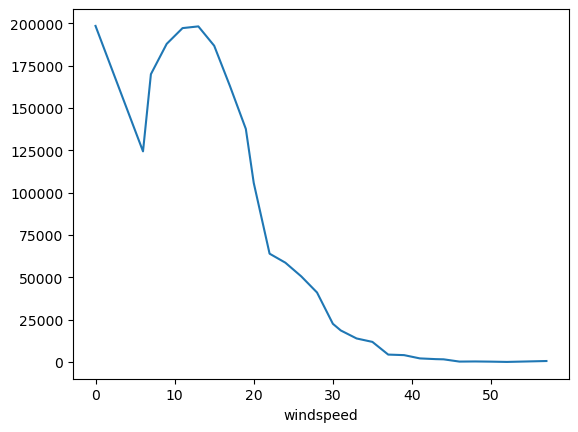

In [45]:
df.groupby('windspeed')['count'].sum().plot.line()

<AxesSubplot: xlabel='windspeed'>

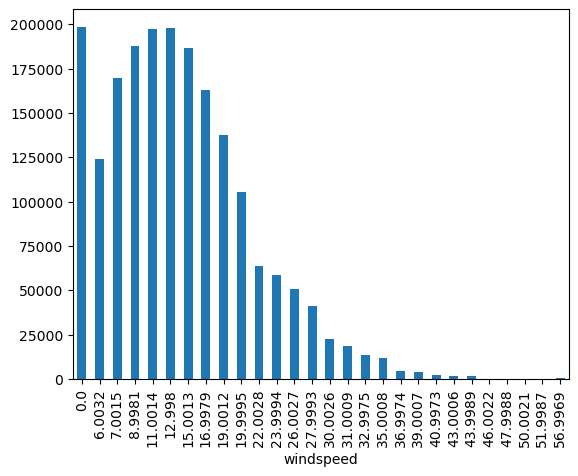

In [48]:
df.groupby('windspeed')['count'].sum().plot.bar()

<AxesSubplot: xlabel='windspeed'>

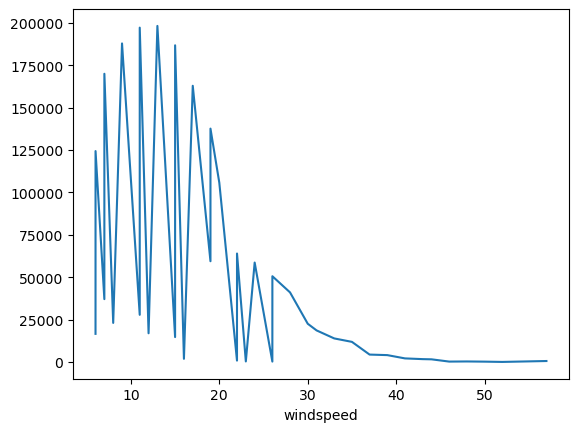

In [9]:
df_wind_fill.groupby('windspeed')['count'].sum().plot.line()

<AxesSubplot: xlabel='windspeed'>

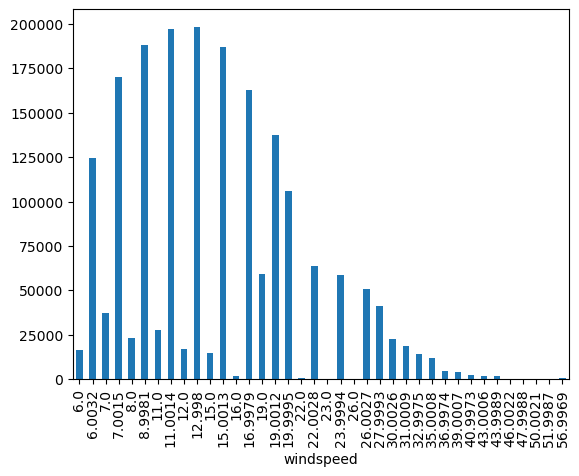

In [10]:
df_wind_fill.groupby('windspeed')['count'].sum().plot.bar()

# Split 0 Wind Data

In [11]:
X = df.drop('count', axis=1)
y = df['count']

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.2, 
                                                  random_state = 10)

In [13]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8591, 10), (2148, 10), (8591,), (2148,))

In [14]:
y_train_log = y_train.apply(lambda x: np.log1p(x)).values
y_val_log = y_val.apply(lambda x: np.log1p(x)).values

# Encode and Transform 0 Wind

In [15]:
bin_and_poly = make_pipeline(
    KBinsDiscretizer(encode='onehot-dense'),
    PolynomialFeatures(include_bias=False,
                       interaction_only=False,
                       degree=3)
)

In [16]:
ohe_poly = make_pipeline(
    OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
    PolynomialFeatures(include_bias=False,
                       interaction_only=False,
                       degree=3)
)   

In [17]:
trans_0_wind = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), ['season','weather','day_of_week']),
    ('b_p', bin_and_poly, ['temp','humidity','windspeed']),
    ('o_p', ohe_poly, ['year', 'hour']),
], remainder = 'passthrough')

In [18]:
trans_0_wind.fit(X_train)
train_0_wind_trans = trans_0_wind.transform(X_train)

# Linear Regression with 0 Wind Values included

In [19]:
# Fitting Regression to Data with Wind = 0
lin_reg = LinearRegression()
X_0_wind = train_0_wind_trans
y_0_train_log = y_train_log
lin_reg.fit(X_0_wind, y_0_train_log)

LinearRegression()

In [20]:
# Transform Validation set, predict, and score
X_0_wind_val = trans_0_wind.transform(X_val)
wind_0_val_pred = lin_reg.predict(X_0_wind_val)

In [21]:
y_val_unlog = np.exp(y_val_log)-1
ypred_unlog = np.exp(wind_0_val_pred)-1

In [22]:
x = ypred_unlog

# Split Windy Data

In [23]:
X_wind = df_wind_fill.drop('count', axis=1)
y_wind = df_wind_fill['count']

In [24]:
X_wind_train, X_wind_val, y_wind_train, y_wind_val = train_test_split(X_wind, 
                                                                      y_wind, 
                                                                      test_size=0.2, 
                                                                      random_state = 10)

In [25]:
X_wind_train.shape, X_wind_val.shape, y_wind_train.shape, y_wind_val.shape

((8591, 10), (2148, 10), (8591,), (2148,))

In [26]:
y_wind_train_log = y_wind_train.apply(lambda x: np.log1p(x)).values
y_wind_val_log = y_wind_val.apply(lambda x: np.log1p(x)).values

# Encode and Transform Windy Data

In [27]:
trans_windy = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), ['season','weather','day_of_week']),
    ('b_p', bin_and_poly, ['temp','humidity','windspeed']),
    ('o_p', ohe_poly, ['year', 'hour']),
], remainder = 'passthrough')

In [28]:
trans_windy.fit(X_wind_train)
train_wind_trans = trans_windy.transform(X_wind_train)

# Linear Regression with Wind

In [29]:
# Data with filled Wind
lin_reg_windy = LinearRegression()
X_windy = train_wind_trans
y_wind_train_log = y_wind_train_log
lin_reg_windy.fit(X_windy, y_wind_train_log)

LinearRegression()

In [30]:
# Transform Validation set, predict, and score
X_windy_val_trans = trans_windy.transform(X_wind_val)
windy_val_pred = lin_reg_windy.predict(X_windy_val_trans)

/opt/anaconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:182: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [31]:
y_windy_val_unlog = np.exp(y_wind_val_log)-1
ypred_windy_unlog = np.exp(windy_val_pred)-1

# Testing the other Regressors on Windy and 0 Wind

In [32]:
m_ridge = Ridge(alpha=0.005, random_state=31)
m_lasso = Lasso(alpha=0.005, random_state=31)
m_elastic_net = ElasticNet(alpha=0.005, l1_ratio=.5,
                           random_state=31)

m_ridge_windy = Ridge(alpha=0.005, random_state=31)
m_lasso_windy = Lasso(alpha=0.005, random_state=31)
m_elastic_windy = ElasticNet(alpha=0.005, l1_ratio=.5,
                           random_state=31)
xgb_windy = xgb.XGBRegressor(random_state=42, 
                             n_estimators=500, 
                             max_depth=4, 
                             learning_rate=0.1)

In [33]:
xgb_model = xgb.XGBRegressor(random_state=42, 
                             n_estimators=500, 
                             max_depth=4, 
                             learning_rate=0.1)

In [34]:
# 0 Wind transformed
# X_0_wind = train_0_wind_trans = X for training
# y_0_train_log = y_train_log = y ''

m_ridge.fit(X_0_wind, y_0_train_log)
m_lasso.fit(X_0_wind, y_0_train_log)
m_elastic_net.fit(X_0_wind, y_0_train_log)
xgb_model.fit(X_0_wind, y_0_train_log)

# Windy transformed
# X_windy = train_wind_trans = X for training
# y_wind_train_log = y_wind_train_log = y ''

m_ridge_windy.fit(X_windy, y_wind_train_log)
m_lasso_windy.fit(X_windy, y_wind_train_log)
m_elastic_windy.fit(X_windy, y_wind_train_log)
xgb_windy.fit(X_windy, y_wind_train_log)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [35]:
# 0 wind predictions
# X_0_wind_val = transformed validation set to predict val
# y_val_log = y_val in log form for validating

yval_ridge = m_ridge.predict(X_0_wind_val)
yval_lasso = m_lasso.predict(X_0_wind_val)
yval_elastic = m_elastic_net.predict(X_0_wind_val)
ypred_XGB = xgb_model.predict(X_0_wind_val)

# Windy predictions
# X_windy_val_trans = transformed validation set to predict val
# y_wind_val_log = y_val in log form for validation

y_windy_ridge = m_ridge_windy.predict(X_windy_val_trans)
y_windy_lasso = m_lasso_windy.predict(X_windy_val_trans)
y_windy_elastic = m_elastic_windy.predict(X_windy_val_trans)
y_windy_XGB = xgb_windy.predict(X_windy_val_trans)

In [36]:
# Unlog y_val 'true' answers
y_val_unlog = np.exp(y_val_log)-1

# Unlog y_windy_val 'true' answers
y_windy_val_unlog = np.exp(y_wind_val_log)-1

# Unlog y_pred values
ypred_ridge_unlog = np.exp(yval_ridge)-1
ypred_lasso_unlog = np.exp(yval_lasso)-1
ypred_elastic_unlog = np.exp(yval_elastic)-1
ypred_XGB_unlog = np.exp(ypred_XGB)-1

# Unlog y_windy_pred values
y_windy_ridge_unlog = np.exp(y_windy_ridge)-1
y_windy_lasso_unlog = np.exp(y_windy_lasso)-1
y_windy_elastic_unlog = np.exp(y_windy_elastic)-1
y_windy_XGB_unlog = np.exp(y_windy_XGB)-1

In [42]:
# RMSLE for 0 Wind values
print('Scores for keeping 0 wind values\n')
print(f'Linear Regression: {mean_squared_log_error(y_val_unlog, ypred_unlog)}')
print(f'Ridge regressor: {mean_squared_log_error(y_val_unlog, ypred_ridge_unlog)}')
print(f'Lasso regressor: {mean_squared_log_error(y_val_unlog, ypred_lasso_unlog)}')
print(f'Elastic Net regressor: {mean_squared_log_error(y_val_unlog, ypred_elastic_unlog)}')
print(f'XGBoost Regeressor: {mean_squared_log_error(y_val_unlog, ypred_XGB_unlog)}')
print('_____________________________________________')
# RMSLE for Windy values
print('\nScores for removing 0 wind values\n')
print(f'Linear Regression: {mean_squared_log_error(y_windy_val_unlog, ypred_windy_unlog)}')
print(f'Ridge regressor: {mean_squared_log_error(y_windy_val_unlog, y_windy_ridge_unlog)}')
print(f'Lasso regressor: {mean_squared_log_error(y_windy_val_unlog, y_windy_lasso_unlog)}')
print(f'Elastic Net regressor: {mean_squared_log_error(y_windy_val_unlog, y_windy_elastic_unlog)}')
print(f'XGBoost Regeressor: {mean_squared_log_error(y_windy_val_unlog, y_windy_XGB_unlog)}')

Scores for keeping 0 wind values

Linear Regression: 0.3403214103255648
Ridge regressor: 0.3363800768090429
Lasso regressor: 0.355069752502424
Elastic Net regressor: 0.3446398637072465
XGBoost Regeressor: 0.10985961974483276
_____________________________________________

Scores for removing 0 wind values

Linear Regression: 0.35182761395803425
Ridge regressor: 0.3477672897886278
Lasso regressor: 0.36551482045658473
Elastic Net regressor: 0.35361054921980495
XGBoost Regeressor: 0.12054938917894063


# Across all models, removing the 0 wind values resulted in worse predictions.